<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/bert_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT

We show how to implement BERT from scratch.
Based on sec 14.8 of http://d2l.ai/chapter_natural-language-processing-pretraining/bert.html




In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math
import collections
import os
import random

import json
import multiprocessing

import torch
from torch import nn
from torch.nn import functional as F

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

# Data

We pretrain on wikitext 2.
This is  smaller than other corpora, so it trains in reasonable time. It retains the original punctuation, making it suitable for next sentence prediction.

Based on sec 14.9 of
http://d2l.ai/chapter_natural-language-processing-pretraining/bert-dataset.html


In [4]:
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    # Uppercase letters are converted to lowercase ones
    paragraphs = [
        line.strip().lower().split(' . ') for line in lines
        if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

## Next sentence prediciton

In [3]:
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # `paragraphs` is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

In [5]:
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # Consider 1 '<cls>' token and 2 '<sep>' tokens
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

## Masked language model

In [6]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # Make a new copy of tokens for the input of a masked language model,
    # where the input may contain replaced '<mask>' or random tokens
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # Shuffle for getting 15% random tokens for prediction in the masked
    # language modeling task
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80% of the time: replace the word with the '<mask>' token
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.randint(0, len(vocab) - 1)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

In [7]:
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # `tokens` is a list of strings
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language modeling
        # task
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

## Padding

In [8]:
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens, = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(
            torch.tensor(
                token_ids + [vocab['<pad>']] * (max_len - len(token_ids)),
                dtype=torch.long))
        all_segments.append(
            torch.tensor(segments + [0] * (max_len - len(segments)),
                         dtype=torch.long))
        # `valid_lens` excludes count of '<pad>' tokens
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(
            torch.tensor(
                pred_positions + [0] *
                (max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # Predictions of padded tokens will be filtered out in the loss via
        # multiplication of 0 weights
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] *
                         (max_num_mlm_preds - len(pred_positions)),
                         dtype=torch.float32))
        all_mlm_labels.append(
            torch.tensor(
                mlm_pred_label_ids + [0] *
                (max_num_mlm_preds - len(mlm_pred_label_ids)),
                dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

## Putting it altogether

In [9]:
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # Input `paragraphs[i]` is a list of sentence strings representing a
        # paragraph; while output `paragraphs[i]` is a list of sentences
        # representing a paragraph, where each sentence is a list of tokens
        paragraphs = [
            d2l.tokenize(paragraph, token='word') for paragraph in paragraphs]
        sentences = [
            sentence for paragraph in paragraphs for sentence in paragraph]
        self.vocab = d2l.Vocab(
            sentences, min_freq=5,
            reserved_tokens=['<pad>', '<mask>', '<cls>', '<sep>'])
        # Get data for the next sentence prediction task
        examples = []
        for paragraph in paragraphs:
            examples.extend(
                _get_nsp_data_from_paragraph(paragraph, paragraphs,
                                             self.vocab, max_len))
        # Get data for the masked language model task
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab) +
                     (segments, is_next))
                    for tokens, segments, is_next in examples]
        # Pad inputs
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights, self.all_mlm_labels,
         self.nsp_labels) = _pad_bert_inputs(examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

In [10]:
def load_data_wiki(batch_size, max_len):
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    return train_iter, train_set.vocab

In [15]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


# Model

## Encoder

In [16]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

In [17]:
class BERTEncoder(nn.Module):
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                f"{i}",
                d2l.EncoderBlock(key_size, query_size, value_size,
                                 num_hiddens, norm_shape, ffn_num_input,
                                 ffn_num_hiddens, num_heads, dropout, True))
        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # Shape of `X` remains unchanged in the following code snippet:
        # (batch size, max sequence length, `num_hiddens`)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [18]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,
                      ffn_num_hiddens, num_heads, num_layers, dropout)

In [19]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

## Loss

In [20]:
class MaskLM(nn.Module):
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(), nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [21]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [22]:
class NextSentencePred(nn.Module):
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

In [23]:
encoded_X = torch.flatten(encoded_X, start_dim=1)
# input_shape for NSP: (batch size, `num_hiddens`)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

## Putting it altogether

In [24]:
class BERTModel(nn.Module):
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                                   ffn_num_input, ffn_num_hiddens, num_heads,
                                   num_layers, dropout, max_len=max_len,
                                   key_size=key_size, query_size=query_size,
                                   value_size=value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

# Pre-training

In [25]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

In [27]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X,
                         valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y,
                         nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1), pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [28]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=1e-3)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss', xlim=[1, num_steps],
                            legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

MLM loss 5.424, NSP loss 0.699
12184.5 sentence pairs/sec on [device(type='cuda', index=0)]


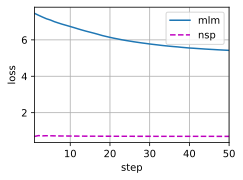

In [30]:
nsteps = 50
train_bert(train_iter, net, loss, len(vocab), devices, nsteps)

# Extracting the output encoding

In [31]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [38]:
# Encoding of 1 sentnence. 
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :] # cls is token 0
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape


(torch.Size([1, 6, 128]), torch.Size([1, 128]))

# Pre-trained model

Lots of pre-trained transformers are available from [huggingface.co](https://https://huggingface.co/).
Here we use some models from [d2l.ai](https://d2l.ai).


In [2]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [3]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {
        token: idx for idx, token in enumerate(vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    # Load pretrained BERT parameters
    bert.load_state_dict(
        torch.load(os.path.join(data_dir, 'pretrained.params')))
    return bert, vocab

In [4]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model('bert.small', num_hiddens=256,
                                    ffn_num_hiddens=512, num_heads=4,
                                    num_layers=2, dropout=0.1, max_len=512,
                                    devices=devices)

# Fine tuning

We use the stanford natural language inference dataset, as in [this colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/entailment_attention_mlp_torch.ipynb)

In [5]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(*[
                d2l.tokenize([s.lower() for s in sentences])
                for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments,
                             dtype=torch.long), torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [6]:
# Reduce `batch_size` if there is an out of memory error. 
#In the original BERT model, `max_len` = 512
#batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
batch_size, max_len, num_workers = 256, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                         num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                        num_workers=num_workers)

read 549367 examples
read 9824 examples


In [7]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In [8]:
net = BERTClassifier(bert)

loss 0.501, train acc 0.800, test acc 0.788
5070.0 examples/sec on [device(type='cuda', index=0)]


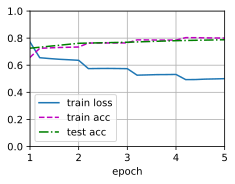

In [9]:
lr, num_epochs = 1e-4, 2
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)